In [1]:
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import seaborn as sns
import time
import warnings

import scipy.ndimage.filters
import scipy.stats as stats

from IPython.display import display, clear_output

import nelpy as nel
import nelpy.plotting as npl

from nelpy.analysis.hmm_sparsity import HMMSurrogate

from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1 import make_axes_locatable

from nelpy import hmmutils
from nelpy.decoding import k_fold_cross_validation
from nelpy.decoding import decode1D

# Set default figure aesthetics
npl.setup(font_scale=2.0)

%matplotlib inline

warnings.filterwarnings("ignore")

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.


In [2]:
import gcsfs
import pandas as pd
import os

load_local = False

if not load_local:
    fs = gcsfs.GCSFileSystem(project='polar-program-784', token='cloud')
    print(fs.ls('kemerelab-data/diba'))

    with fs.open('kemerelab-data/diba/gor01vvp01pin01-metadata.h5', 'rb') as fid:
        with pd.HDFStore('gor01vvp01pin01-metadata.h5', mode="r", driver="H5FD_CORE",
                driver_core_backing_store=0,
                driver_core_image=fid.read()
                ) as store:
            df = store['Session_Metadata']
            df2 = store['Subset_Metadata']
            
    with fs.open('kemerelab-data/diba/gor01vvp01pin01_processed_speed.nel', 'rb') as fid:
        jar = nel.load_pkl('',fileobj=fid) # currently requires a specific nelpy branch

else:
    datadirs = ['/Users/ckemere/Development/Data/Buzsaki/']

    fileroot = next( (dir for dir in datadirs if os.path.isdir(dir)), None)
    if fileroot is None:
        raise FileNotFoundError('datadir not found')

    with pd.HDFStore(fileroot + 'gor01vvp01pin01-metadata.h5') as store:
        df = store.get('Session_Metadata')
        df2 = store.get('Subset_Metadata')
        
    jar = nel.load_pkl(fileroot + 'gor01vvp01pin01_processed_speed.nel')


exp_data = jar.exp_data
aux_data = jar.aux_data
del jar            

['kemerelab-data/diba/', 'kemerelab-data/diba/gor01vvp01-metadata.h5', 'kemerelab-data/diba/gor01vvp01_processed_speed.nel', 'kemerelab-data/diba/gor01vvp01pin01-metadata.h5', 'kemerelab-data/diba/gor01vvp01pin01_processed_speed.nel']


# Draw real place fields

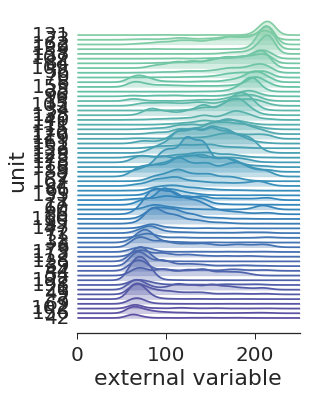

In [3]:
# session_time, segment = '1-22-43', 'long'
# session_time, segment = '16-40-19', 'short'

session_time, segment = '22-24-40', 'short'

PBEs = aux_data[session_time][segment]['PBEs']
st_run = aux_data[session_time][segment]['st_run']
tc = aux_data[session_time][segment]['tc']
tc_placecells = aux_data[session_time][segment]['tc_placecells']

#####################################################################

NUM_COLORS = tc_placecells.n_units * 4

cm = plt.get_cmap('Spectral_r')
clist = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
clist = np.roll(clist, 0, axis=0)

npl.set_palette(clist)

with npl.FigureManager(show=True, figsize=(4,6)) as (fig, ax):
    ax = npl.plot_tuning_curves1D(tc_placecells.smooth(sigma=3), pad=2.5);
    ax.set_xlim(0,250)

### Compute cross-validate sequence score distributions for RUN data in 4 sessions

In [4]:
from dask.distributed import Client
client = Client('tcp://127.0.0.1:38306')  # set up local cluster on your laptop
client

Client Scheduler: tcp://127.0.0.1:38306 Dashboard: http://127.0.0.1:8787,Cluster Workers: 32 Cores: 32 Memory: 126.75 GB


In [5]:
import dask
from dask import delayed

def est_model(data, num_states, seed):
    hmm = nel.hmmutils.PoissonHMM(n_components=num_states, random_state=seed, verbose=False)
    hmm.fit(data)
    return hmm

def score_data(data, hmm):
    seq_lens = np.array([seq.n_bins for seq in data])
    return hmm.score(data) / seq_lens


In [6]:
ds_run = 0.125 # 125 ms bin size for Run
ds_50ms = 0.05 # used for smoothing
ds = 0.02 # 20 ms bin size for PBEs

sigma = 0.25 # 250 ms spike smoothing

num_states = 30

k_folds = 5

In [7]:
print('Building model for Session {}, {} segment'.format(session_time, segment))
s = np.argwhere([segment == segment_label for segment_label in df[df.time==session_time]['segment_labels'].values.tolist()[0]])
st_run = exp_data[session_time]['spikes'][s][exp_data[session_time]['run_epochs']]

# smooth and re-bin RUN data:
bst = st_run.bin(ds=ds_50ms).smooth(sigma=sigma, inplace=True).rebin(w=ds_run/ds_50ms)
    

Building model for Session 22-24-40, short segment


# Analyze sparsity of PBE model

In [8]:
# get spike train
st = exp_data[session_time]['spikes']
# restrict spikes to only PBEs:
mua_spks = st[aux_data[session_time][segment]['PBEs'].support]

random_state = 1
test_size = 0.2
description = (session_time, segment)
verbose = False

hmm_actual = HMMSurrogate(kind='actual', 
                          st=mua_spks, 
                          num_states=num_states, 
                          ds=ds, 
                          test_size=test_size, 
                          random_state=random_state, 
                          description=description,
                          verbose=verbose)

hmm_coherent = HMMSurrogate(kind='coherent', 
                                       st=mua_spks, 
                                       num_states=num_states, 
                                       ds=ds, 
                                       test_size=test_size, 
                                       random_state=random_state, 
                                       description=description,
                                       verbose=verbose)

hmm_poisson = HMMSurrogate(kind='poisson', 
                                       st=mua_spks, 
                                       num_states=num_states, 
                                       ds=ds, 
                                       test_size=test_size, 
                                       random_state=random_state, 
                                       description=description,
                                       verbose=verbose)

hmms = [hmm_actual,
        hmm_coherent,
        hmm_poisson]

In [9]:
n_shuffles = 1

for nn in range(n_shuffles):
    print('starting {}'.format(nn))
    for hmm in hmms:
        print("shuffling", hmm.label)
        hmm.shuffle()
        print("fitting", hmm.label)
        hmm.fit()
        print("scoring", hmm.label)
        
        # calculate and aggregate various gini coefficients
        hmm.score_gini(kind='tmat')
        hmm.score_gini(kind='lambda')
        hmm.score_gini(kind='tmat_arrival')
        hmm.score_gini(kind='tmat_departure')
        hmm.score_gini(kind='lambda_across_states')
        hmm.score_gini(kind='lambda_across_units')
        
        # calculate and aggregate bottleneck_ratios
        hmm.score_bottleneck_ratio(n_samples=20000)
        
    print('completed {}'.format(nn))

        # calculate and aggregate mixing time

        # calculate and aggregate spectrum (or are we only interedted in lambda2 and spectral gap?)

starting 0
shuffling actual
fitting actual
scoring actual
shuffling coherent
fitting coherent
scoring coherent
shuffling poisson
fitting poisson
scoring poisson
completed 0


In [10]:
def score_bottleneck_ratio(transmat, n_samples=50000, verbose=False):
    from nelpy.analysis.ergodic import steady_state
    def Qij(i, j, P, pi):
        return pi[i] * P[i,j]

    def QAB(A, B, P, pi):
        sumQ = 0
        for i in A:
            for j in B:
                sumQ += Qij(i, j, P, pi)
        return sumQ

    def complement(S, Omega):
        return Omega - S

    def Pi(S, pi):
        sumS = 0
        for i in S:
            sumS += pi[i]
        return sumS

    def Phi(S, P, pi, Omega):
        Sc = complement(S, Omega)
        return QAB(S, Sc, P, pi) / Pi(S, pi)

    P = transmat
    num_states = transmat.shape[0]
    Omega = set(range(num_states))
    pi_ = steady_state(P).real

    min_Phi = 1
    for nn in range(n_samples):
        n_samp_in_subset = np.random.randint(1, num_states-1)
        S = set(np.random.choice(num_states, n_samp_in_subset, replace=False))
        while Pi(S, pi_) > 0.5:
            n_samp_in_subset -=1
            if n_samp_in_subset < 1:
                n_samp_in_subset = 1
            S = set(np.random.choice(num_states, n_samp_in_subset, replace=False))
        candidate_Phi = Phi(S, P, pi_, Omega)
        if candidate_Phi < min_Phi:
            min_Phi = candidate_Phi
            if verbose:
                print("{}: {} (|S| = {})".format(nn, min_Phi, len(S)))
    return min_Phi

In [39]:

import numpy.linalg as LA

def spectral_gap(transmat):
    evals = LA.eigvals(transmat)
    sorder = np.argsort(np.abs(evals))
    gap = np.real(evals[sorder[-1]] - np.abs(evals[sorder[-2]]))
    return gap

class ColorBarLocator(object):
    def __init__(self, pax, pad=5, width=10):
        self.pax = pax
        self.pad = pad
        self.width = width

    def __call__(self, ax, renderer):
        x, y, w, h = self.pax.get_position().bounds
        fig = self.pax.get_figure()
        inv_trans = fig.transFigure.inverted()
        pad, _ = inv_trans.transform([self.pad, 0])
        width, _ = inv_trans.transform([self.width, 0])
        return [x+w+pad, y, width, h]

def plot_transmat(ax, hmm, edge_threshold=0.0, title='', cbar=True, ylabel=True, **fig_kws):
    cmap = fig_kws.get('cmap', plt.cm.viridis)
    
    num_states = hmm.hmm.n_components
    
    img = ax.matshow(np.where(hmm.hmm.transmat>edge_threshold, hmm.hmm.transmat, 0), cmap=cmap, vmin=0, vmax=1, interpolation='none', aspect='equal')
    ax.set_aspect('equal')
    
    if cbar:
        divider = make_axes_locatable(ax)
#         cax = divider.append_axes("right", size=0.1, pad=0.1)
        cax = fig.add_axes([0,0,0,0], axes_locator=ColorBarLocator(ax))
        cb=plt.colorbar(img, cax=cax)
        cb.set_label('probability', labelpad=-8)
        cb.set_ticks([0,1])
        npl.utils.no_ticks(cax)
        
#     if not cbar:
#         cax.set_visible(False)
    if ylabel:
        ax.set_yticks([0.5, num_states-1.5])
        ax.set_yticklabels(['1', str(num_states)])    
        ax.set_ylabel('state $i$', labelpad=-16)
    else:
        ax.set_yticks([])
        ax.set_yticklabels('')
    
    ax.set_xticks([0.5, num_states-1.5])
    ax.set_xticklabels(['1', str(num_states)])
    ax.set_xbound(lower=0.0, upper=num_states-1)
    ax.set_ybound(lower=0.0, upper=num_states-1)
    
    ax.set_xlabel('state $j$', labelpad=-16)
    
    ax.set_title(title + ' A')
    sns.despine(ax=ax)    
    
def plot_lambda(ax, hmm, cbar=True, ylabel=True, title='', lo=None, **fig_kws):
    import matplotlib.colors as colors

    cmap = fig_kws.get('cmap', plt.cm.viridis)
    norm = fig_kws.get('norm', colors.LogNorm())
    cb_ticks = fig_kws.get('cb_ticks')
    
    num_states = hmm.hmm.n_components
    num_units = hmm.hmm.n_features
    
    ax.set_aspect(num_states/num_units)

    
    if lo is not None:
        img = ax.matshow(hmm.hmm.means[:,lo].T, cmap=cmap, norm=norm, interpolation='none', aspect='auto')
    else:
        img = ax.matshow(hmm.hmm.means.T, cmap=cmap, norm=norm, interpolation='none', aspect='auto')
    
    if cbar:
        divider = make_axes_locatable(ax)
        #cax = fig.add_axes([0,0,0,0], axes_locator=ColorBarLocator(ax))
        cax = divider.append_axes("right", size=0.1, pad=0.1)
        cb=plt.colorbar(img, cax=cax)
        #cb.set_label('firing rate', labelpad=-8)
        cb.set_ticks(cb_ticks)
        #cb.set_ticklabels(['lo', 'hi'])
        npl.utils.no_ticks(cax)
    
    if ylabel:
        ax.set_yticks([0.5, num_units-1.5])
        ax.set_yticklabels(['1', str(num_units)])
        ax.set_ylabel('unit', labelpad=-16)
    else:
        ax.set_yticks([])
        ax.set_yticklabels('')
        
    ax.set_xticks([0.5, num_states-1.5])
    ax.set_xticklabels(['1', str(num_states)])    
    
    ax.set_ybound(lower=0.0, upper=num_units-1)
    ax.set_xbound(lower=0.0, upper=num_states-1)
    
    ax.set_xlabel('state', labelpad=-16)
    ax.set_title(title + ' $\Lambda$')
    sns.despine(ax=ax)   
    
def plot_sun_graph(ax, hmm, edge_threshold=0.0, lw=2, ec='k', nc='k', node_size=3, **fig_kws):
    plt.sca(ax)
    
    Gi = npx.inner_graph_from_transmat(hmm.hmm.transmat)
    Go = npx.outer_graph_from_transmat(hmm.hmm.transmat)
    
    npx.draw_transmat_graph_inner(Gi, edge_threshold=edge_threshold, lw=lw, ec=ec, node_size=node_size)
    npx.draw_transmat_graph_outer(Go, Gi, edge_threshold=edge_threshold, lw=lw, ec=ec, nc=nc, node_size=node_size*2)

    ax.set_xlim(-1.4,1.4)
    ax.set_ylim(-1.4,1.4)
#     ax0, img = npl.imagesc(hmm.transmat, ax=axes[0])
    npl.utils.clear_left_right(ax)
    npl.utils.clear_top_bottom(ax)
    
#     ax.set_title('1 - $|\lambda_2| =$ {0:.2f}'.format(float(spectral_gap(hmm.hmm.transmat))))
    ax.set_title('$\gamma^*=$ {0:.3f}'.format(float(spectral_gap(hmm.hmm.transmat))), y=1.02)
    
    ax.set_aspect('equal')
    
def plot_connectivity_graph(ax, hmm, edge_threshold=0.0, lw=2, ec='k', node_size=3, **fig_kws):
    plt.sca(ax)
    
    G = npx.graph_from_transmat(hmm.hmm.transmat)
    
    npx.draw_transmat_graph(G, edge_threshold=edge_threshold, lw=lw, ec=ec, node_size=node_size)
#     ax.set_xlim(-1.3,1.3)
#     ax.set_ylim(-1.3,1.3)
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
#     ax0, img = npl.imagesc(hmm.transmat, ax=axes[0])
    npl.utils.clear_left_right(ax)
    npl.utils.clear_top_bottom(ax)
    ax1.set_aspect('equal')
    
def plot_transmat_gini_departure(ax, hmms, n_max=500, **fig_kws):
    
    hist_kws={"range": (0.5, 1)}
    bins=50

    with sns.color_palette("Blues_d", 8):
        for hmm in hmms:
            data = np.array(hmm.results['gini_tmat_departure'])
            data = data[:n_max,:]
            sns.distplot(data.sum(axis=0)/len(data), hist=False, hist_kws=hist_kws, bins=bins, label=hmm.label, ax=ax)

    ax.set_title('tmat gini departure, N=250')
    
    ax.set_xlim(0.6, 0.9)
    
    sns.despine(ax=ax)
    
def plot_transmat_gini_arrival(ax, hmms, n_max=500, **fig_kws):
    
    hist_kws={"range": (0.8, 1)}
    bins=50

    with sns.color_palette("Blues_d", 8):
        for hmm in hmms:
            data = np.array(hmm.results['gini_tmat_arrival'])
            data = data[:n_max,:]
            sns.distplot(data.sum(axis=0)/len(data), hist=False, hist_kws=hist_kws, bins=bins, label=hmm.label, ax=ax)

    ax.set_title('tmat gini arrival, N=250')
    ax.legend('')
    ax.set_xlim(0.7, 1)
    
    sns.despine(ax=ax)
    
def plot_bottleneck(ax, hmms, n_max=500, **fig_kws):
    
    hist_kws={"range": (0, 0.5)}
    bins=50

    for hmm in hmms:
        data = np.array(hmm.results['bottleneck'])
        data = data[:n_max]
        sns.distplot(data, hist=False, hist_kws=hist_kws, bins=bins, label=hmm.label, ax=ax)

    ax.set_title('bottleneck, N=250')
    
    ax.legend('')
    
    ax.set_xlim(0, 0.5)
    
    sns.despine(ax=ax)
    
def plot_gini_lambda(ax, hmms, n_max=500, **fig_kws):
    
    hist_kws={"range": (0.7, 0.9)}
    bins=50

    for hmm in hmms:
        data = np.array(hmm.results['gini_lambda'])
        data = data[:n_max]
        sns.distplot(data, hist=False, hist_kws=hist_kws, bins=bins, label=hmm.label, ax=ax)

    ax.set_title('lambda gini, N=250')
    ax.legend('')
    ax.set_xlim(0.7, 0.9)
    
    sns.despine(ax=ax)
    
def plot_lambda_gini_across_states(ax, hmms, n_max=5000, **fig_kws):
    
    hist_kws={"range": (0.0, 1)}
    bins=30

    for hmm in hmms:
        data = np.array(hmm.results['gini_lambda_across_states'])
        data = data[:n_max,:]
        sns.distplot(data.sum(axis=0)/len(data), hist_kws=hist_kws, bins=bins, hist=False, kde=True, label=hmm.label, ax=ax, kde_kws={'bw':0.05})
    
    ax.set_title('lambda gini across states, N=250')
    ax.legend('')
    ax.set_xlim(0., 1)
    
    sns.despine(ax=ax)




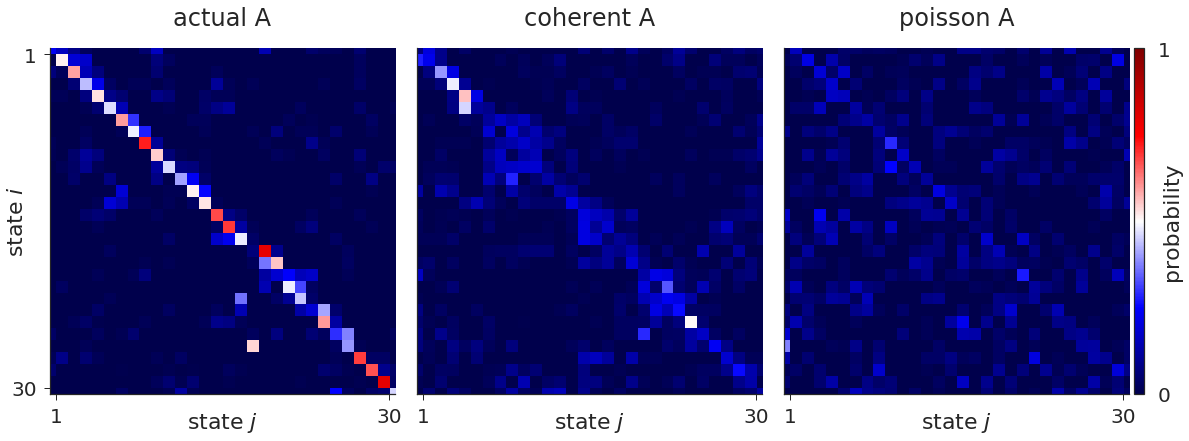

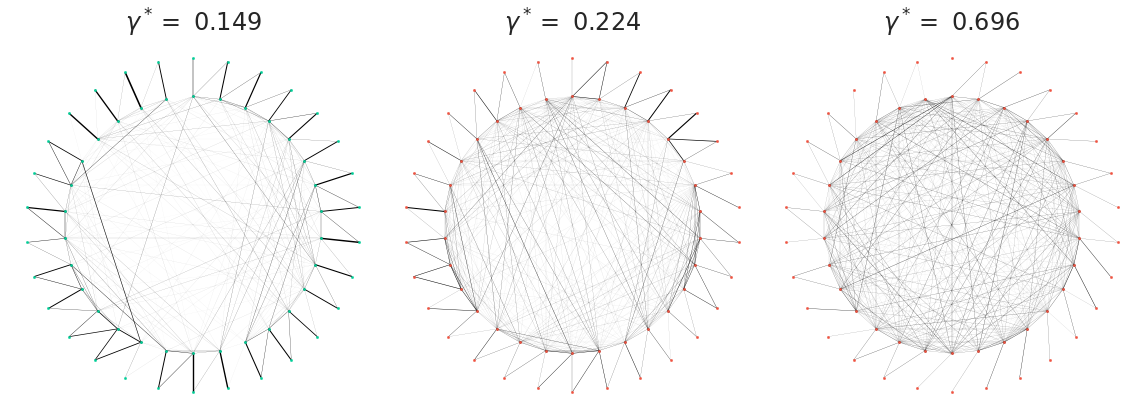

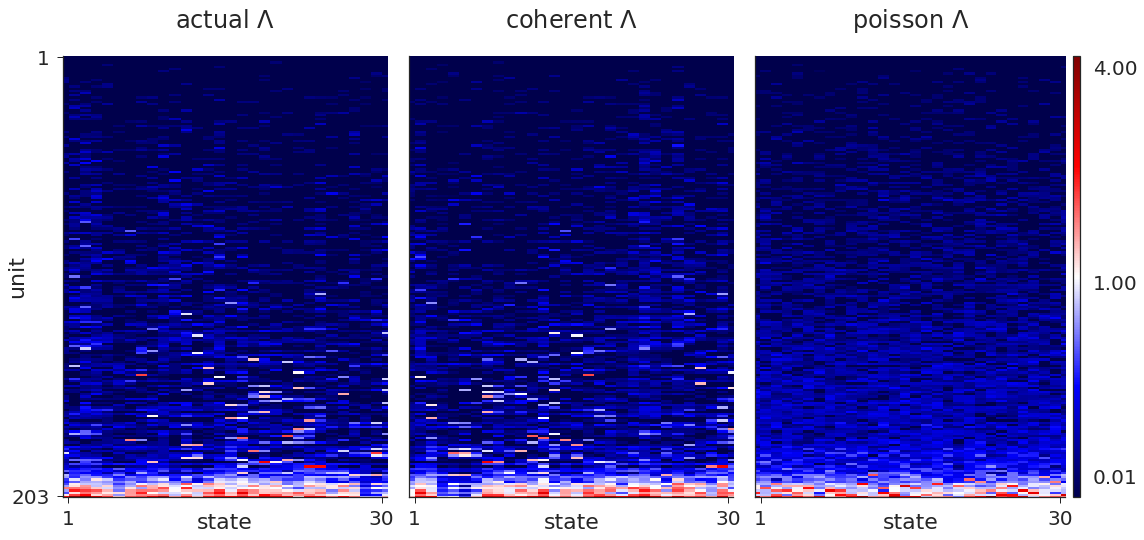

In [37]:
import nelpy.plotting.graph as npx
import matplotlib.colors as colors

# fig = plt.figure(1, figsize=(6, 6))
fig, axes = plt.subplots(1,3, figsize=(16, 14))

## define figure parameters and color pallete
text_kws = dict(ha="center", size=7)
fig_kws = dict(text_kws=text_kws, cmap=plt.cm.seismic)


lambda_order = np.argsort(hmms[0].hmm.means.sum(axis=0))
# plt.matshow(hmm.means[:,no].T, cmap=plt.cm.Spectral_r)
plot_transmat(axes[0], hmm=hmms[0], title=hmms[0].label, cbar=False, **fig_kws)
plot_transmat(axes[1], hmm=hmms[1], title=hmms[1].label, cbar=False, ylabel=False, **fig_kws)
plot_transmat(axes[2], hmm=hmms[2], title=hmms[2].label, cbar=True, ylabel=False, **fig_kws)
fig.tight_layout(h_pad=.5, w_pad=0.75, rect=[0, .05, 1, 1])


fig, axes = plt.subplots(1,3, figsize=(16, 14))
plot_sun_graph(axes[0], hmm=hmms[0], nc=npl.colors.sweet.green, **fig_kws)
plot_sun_graph(axes[1], hmm=hmms[1], nc=npl.colors.sweet.red, **fig_kws)
plot_sun_graph(axes[2], hmm=hmms[2], nc=npl.colors.sweet.red, **fig_kws)
fig.tight_layout(h_pad=.5, w_pad=0.75, rect=[0, .05, 1, 1])

vmin= hmms[0].hmm.means.min()
vmax = hmms[0].hmm.means.max()
lambda_kws = dict(text_kws=text_kws, cmap=plt.cm.seismic, norm=colors.PowerNorm(0.5))
# lambda_kws = dict(text_kws=text_kws, cmap=plt.cm.seismic, norm=colors.LogNorm(vmin=vmin, vmax=vmax))

fig, axes = plt.subplots(1,3, figsize=(16,8))
plot_lambda(axes[0], hmm=hmms[0], title=hmms[0].label, cbar=False, lo=lambda_order, **lambda_kws)
plot_lambda(axes[1], hmm=hmms[1], title=hmms[1].label, ylabel=False, lo=lambda_order, cbar=False, **lambda_kws)
plot_lambda(axes[2], hmm=hmms[2], title=hmms[2].label, ylabel=False, lo=lambda_order, cbar=True, cb_ticks=[0.01,1,4], **lambda_kws)
fig.tight_layout(h_pad=.5, w_pad=0.75, rect=[0, .05, 1, 1])

# plot_transmat_gini_departure(axes[3], [hmms[0], hmms[1], hmms[2]], **fig_kws)
# # plot_transmat_gini_arrival(axes[19], hmms, **fig_kws)
# plot_lambda_gini_across_states(axes[7], [hmms[0], hmms[1], hmms[2]], **fig_kws)
# # plot_gini_lambda(axes[7], [hmms[0], hmms[2], hmms[3]], **fig_kws)
# plot_bottleneck(axes[11], [hmms[0], hmms[1], hmms[2]], **fig_kws)

# plot_obsmat(axes[1], **fig_kws)

# ## label the panels
# label_panels(fig, size=18)

# fig.tight_layout()

# npl.savefig('b_sparsity', formats=['pdf', 'png', 'svg'])

# Analyze sparsity of RUN data

In [27]:
# get run spikes
s = np.argwhere([segment == segment_label for segment_label in df[df.time==session_time]['segment_labels'].values.tolist()[0]])
run_spks = exp_data[session_time]['spikes'][s][exp_data[session_time]['run_epochs']]

random_state = 1
test_size = 0.2
description = (session_time, segment)
verbose = False

hmm_actual = HMMSurrogate(kind='actual', 
                          st=run_spks, 
                          num_states=num_states, 
                          ds=ds_run, 
                          test_size=test_size, 
                          random_state=random_state, 
                          description=description,
                          verbose=verbose)

hmm_coherent = HMMSurrogate(kind='coherent', 
                                       st=run_spks, 
                                       num_states=num_states, 
                                       ds=ds_run, 
                                       test_size=test_size, 
                                       random_state=random_state, 
                                       description=description,
                                       verbose=verbose)

hmm_poisson = HMMSurrogate(kind='poisson', 
                                       st=run_spks, 
                                       num_states=num_states, 
                                       ds=ds_run, 
                                       test_size=test_size, 
                                       random_state=random_state, 
                                       description=description,
                                       verbose=verbose)

run_hmms = [hmm_actual,
        hmm_coherent,
        hmm_poisson]

In [28]:
n_shuffles = 1

for nn in range(n_shuffles):
    print('starting {}'.format(nn))
    for hmm in run_hmms:
        print("shuffling", hmm.label)
        hmm.shuffle()
        print("fitting", hmm.label)
        hmm.fit()
        print("scoring", hmm.label)
        
        # calculate and aggregate various gini coefficients
        hmm.score_gini(kind='tmat')
        hmm.score_gini(kind='lambda')
        hmm.score_gini(kind='tmat_arrival')
        hmm.score_gini(kind='tmat_departure')
        hmm.score_gini(kind='lambda_across_states')
        hmm.score_gini(kind='lambda_across_units')
        
        # calculate and aggregate bottleneck_ratios
        hmm.score_bottleneck_ratio(n_samples=20000)
        
    print('completed {}'.format(nn))

        # calculate and aggregate mixing time

        # calculate and aggregate spectrum (or are we only interedted in lambda2 and spectral gap?)

starting 0
shuffling actual
fitting actual
scoring actual
shuffling coherent
fitting coherent
scoring coherent
shuffling poisson
fitting poisson
scoring poisson
completed 0


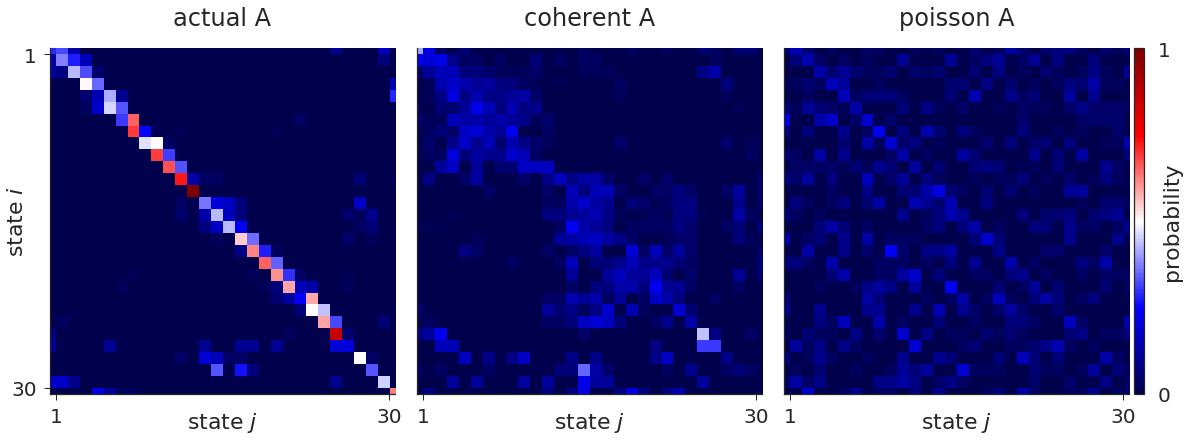

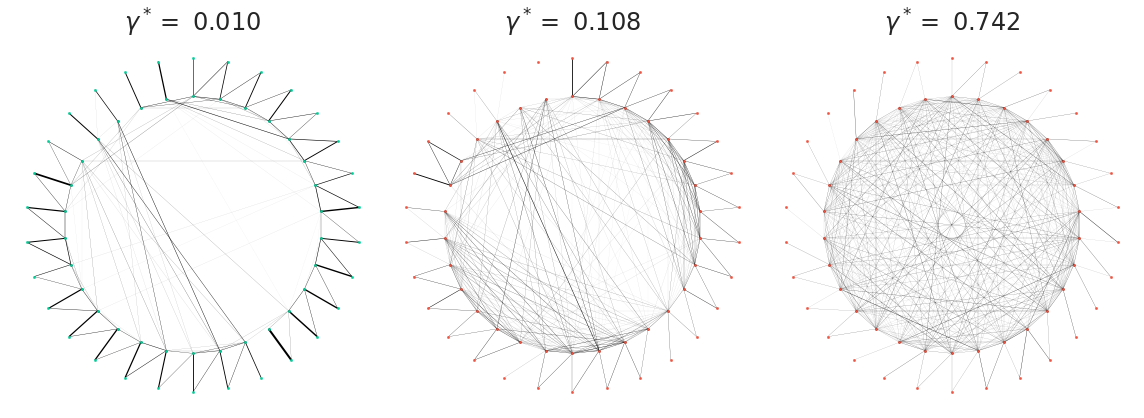

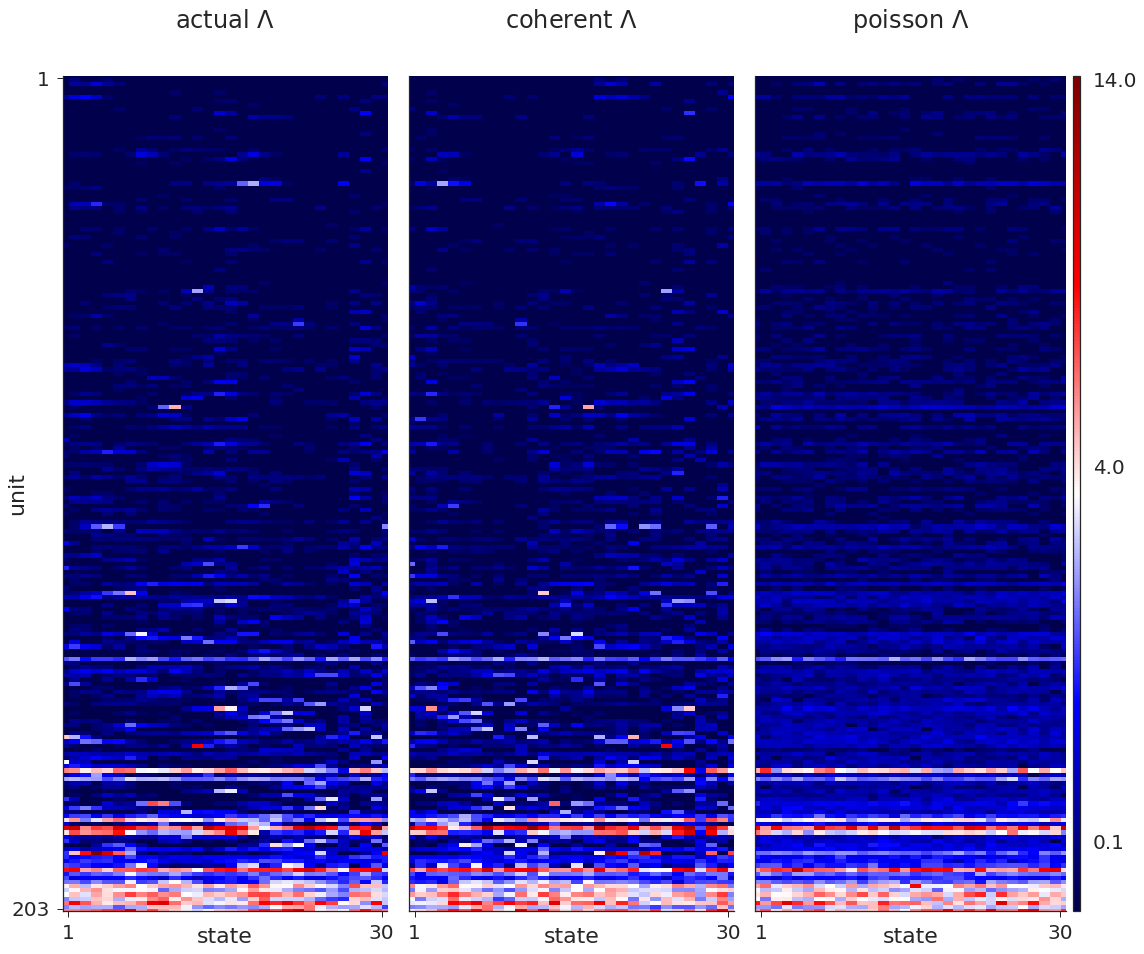

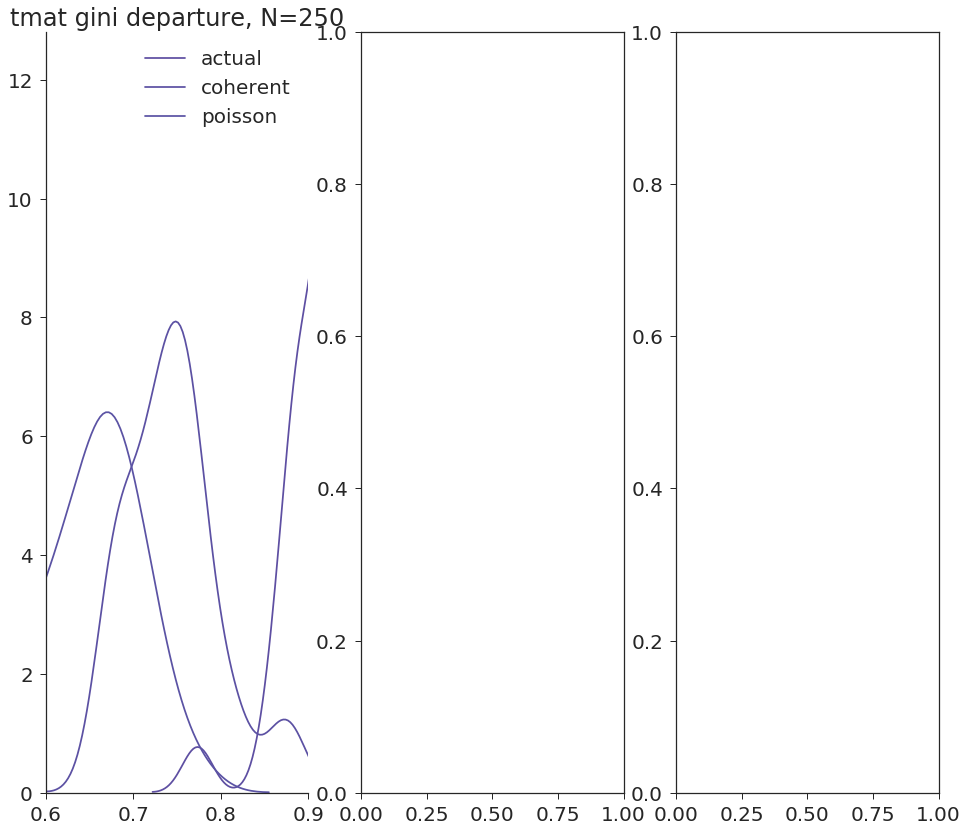

In [41]:
import nelpy.plotting.graph as npx

# fig = plt.figure(1, figsize=(6, 6))
fig, axes = plt.subplots(1,3, figsize=(16, 14))

## define figure parameters and color pallete
text_kws = dict(ha="center", size=7)
fig_kws = dict(text_kws=text_kws, cmap=plt.cm.seismic)


lambda_order = np.argsort(hmms[0].hmm.means.sum(axis=0))
# plt.matshow(hmm.means[:,no].T, cmap=plt.cm.Spectral_r)
plot_transmat(axes[0], hmm=run_hmms[0], title=run_hmms[0].label, cbar=False, **fig_kws)
plot_transmat(axes[1], hmm=run_hmms[1], title=run_hmms[1].label, cbar=False, ylabel=False, **fig_kws)
plot_transmat(axes[2], hmm=run_hmms[2], title=run_hmms[2].label, cbar=True, ylabel=False, **fig_kws)
fig.tight_layout(h_pad=.5, w_pad=0.75, rect=[0, .05, 1, 1])


fig, axes = plt.subplots(1,3, figsize=(16, 14))
plot_sun_graph(axes[0], hmm=run_hmms[0], nc=npl.colors.sweet.green, **fig_kws)
plot_sun_graph(axes[1], hmm=run_hmms[1], nc=npl.colors.sweet.red, **fig_kws)
plot_sun_graph(axes[2], hmm=run_hmms[2], nc=npl.colors.sweet.red, **fig_kws)
fig.tight_layout(h_pad=.5, w_pad=0.75, rect=[0, .05, 1, 1])

vmin= hmms[0].hmm.means.min()
vmax = hmms[0].hmm.means.max()
lambda_kws = dict(text_kws=text_kws, cmap=plt.cm.seismic, norm=colors.PowerNorm(0.5))
# lambda_kws = dict(text_kws=text_kws, cmap=plt.cm.seismic, norm=colors.LogNorm(vmin=vmin, vmax=vmax))
fig, axes = plt.subplots(1,3, figsize=(16,14))
plot_lambda(axes[0], hmm=run_hmms[0], title=run_hmms[0].label, cbar=False, lo=lambda_order, **lambda_kws)
plot_lambda(axes[1], hmm=run_hmms[1], title=run_hmms[1].label, ylabel=False, lo=lambda_order, cbar=False, **lambda_kws)
plot_lambda(axes[2], hmm=run_hmms[2], title=run_hmms[2].label, ylabel=False, lo=lambda_order, cbar=True, cb_ticks=[0.1, 4, 14], **lambda_kws)
fig.tight_layout(h_pad=.5, w_pad=0.75, rect=[0, .05, 1, 1])

fig, axes = plt.subplots(1,3, figsize=(16,14))
plot_transmat_gini_departure(axes[0], run_hmms, **fig_kws)
# # plot_transmat_gini_arrival(axes[19], hmms, **fig_kws)
#plot_lambda_gini_across_states(axes[1], run_hmms, **fig_kws)
# # plot_gini_lambda(axes[7], [hmms[0], hmms[2], hmms[3]], **fig_kws)
#plot_bottleneck(axes[2], run_hmms, **fig_kws)

# plot_obsmat(axes[1], **fig_kws)

# ## label the panels
# label_panels(fig, size=18)

# fig.tight_layout()

# npl.savefig('b_sparsity', formats=['pdf', 'png', 'svg'])

# Compute virtual tuning curves...

In [ ]:
# OK - let's think about what we want to do:

# Big question - what is the latent space that describes hippocampal activity?
#  (1) - what does that latent space look like?
#      - transition matrix and firing rate matrix
#      - sparsity, compared with shuffles?
#      - cross-validated virtual tuning curves
#  (2) - we can learn models on both place cell activity and PBEs
#      - are they equivalent?
#       : latent space looks qualitatively similar
#      - how do they differ?
#       : cross-validated likelihood (goodness-of-fit) is more different than shuffles?
#       : is there something to be said about scoring? maybe PBE-in-place cell better than
#          place cell in PBE
#  (3) - can we see replay?


# (0) replicate cross-modal scoring
#    - cross-validated self scoring (train model on subsets, test on the rest)
#    - cross-modal scoring (train model on whole set)
#    - have to deal with sequence length, but can compare by sequence
# 
# (1) cross-validation training curves comparing to shuffles?
#    - this could be the way Kamran suggested (just shuffling the test set)
#    - this could also be the way Etienne suggested (shuffling all the data, then training as usual)
#
# (2) generate sparsity data for transition and rate matrices
#
# (3) Is there a way to think about mutual information??? I think it would be hard, because I think 
#     the operant question would be MI(spikes | position) and MI(spikes | latent state)

### Calculate virtual tuning curves for RUN HMM and compare with PBE

In [ ]:
# session_time, segment = ('16-40-19', 'short') # example session

num_states = 30 # number of states for PBE HMM
min_tc_duration = 0 # mininmum observation time in seconds, before a bin contributes to the tuning curve
sigma_tc = 4 # 4 cm smoothing on tuning curves

description = (session_time, segment)
print("session: {}".format(description))

s = np.argwhere([segment == segment_label for segment_label in df[df.time==session_time]['segment_labels'].values.tolist()[0]])
st_run = exp_data[session_time]['spikes'][s][exp_data[session_time]['run_epochs']]

# smooth and re-bin:
sigma = 0.3 # 300 ms spike smoothing
bst_run = st_run.bin(ds=ds_50ms).smooth(sigma=sigma, inplace=True).rebin(w=ds_run/ds_50ms)
bst = bst_run


pos = exp_data[session_time]['pos1d'] # should this be pos1d?

ext_nx=124
x0=0; xl=310;

xx_left = np.linspace(x0,xl,ext_nx+1)
xx_mid = np.linspace(x0,xl,ext_nx+1)[:-1]; xx_mid += (xx_mid[1]-xx_mid[0])/2

#########################################################
# Generate an HMM trained on all PBEs 
PBEs = aux_data[session_time][segment]['PBEs']
pbe_hmm = nel.hmmutils.PoissonHMM(n_components=num_states, random_state=0, verbose=False)
pbe_hmm.fit(PBEs)
transmat_order = pbe_hmm.get_state_order('transmat')
pbe_hmm.reorder_states(transmat_order)

xpos = pos.asarray(at=bst_run.centers).yvals

ext_x = np.digitize(xpos, xx_left) - 1 # spatial bin numbers
ext_x = ext_x.astype(float)
ext_x[ext_x==0] = np.nan
ext_x[ext_x>=ext_nx] = np.nan

extern = pbe_hmm.fit_ext(X=bst_run, ext=ext_x, n_extern=ext_nx)

pbe_vtc = nel.TuningCurve1D(ratemap=extern, min_duration=min_tc_duration, extmin=x0, extmax=xl)
pbe_vtc = pbe_vtc.smooth(sigma=sigma_tc)
pbe_vtc.reorder_units(inplace=True)
#########################################################

k_folds = 3
vtcs_run = []
X = list(range(bst_run.n_epochs))

for kk, (training, validation) in enumerate(k_fold_cross_validation(X, k=k_folds)):     
    print('  fold {}/{}'.format(kk+1, k_folds))

    RunSeqs_train = bst[training]
    RunSeqs_test = bst[validation]

    # train HMM on all training PBEs
    hmm = nel.hmmutils.PoissonHMM(n_components=num_states, random_state=0, verbose=False)
    hmm.fit(RunSeqs_train)

    # reorder states according to transmat ordering
    transmat_order = hmm.get_state_order('transmat')
    hmm.reorder_states(transmat_order)

    # compute spatial info on non-shuffled data:
    xpos = pos.asarray(at=RunSeqs_test.centers).yvals

    ext_x = np.digitize(xpos, xx_left) - 1 # spatial bin numbers
    ext_x = ext_x.astype(float)
    ext_x[ext_x==0] = np.nan
    ext_x[ext_x>=ext_nx] = np.nan

    extern = hmm.fit_ext(X=RunSeqs_test, ext=ext_x, n_extern=ext_nx)

    vtc = nel.TuningCurve1D(ratemap=extern, min_duration=min_tc_duration, extmin=x0, extmax=xl)
    vtc = vtc.smooth(sigma=sigma_tc)
    
    vtc.reorder_units(inplace=True)
    
    vtcs_run.append(vtc)
    

In [ ]:
NUM_COLORS = vtc.n_units + 2

cm = plt.get_cmap('viridis')
clist = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

npl.set_palette(clist)

for vtc in vtcs_run:
    fig, axs = plt.subplots(1,2,figsize=(12,6))
    npl.plot_tuning_curves1D(vtc, pad=0.1, ax=axs[0])
    npl.plot_tuning_curves1D(pbe_vtc, pad=0.1, ax=axs[1])
    plt.show()

In [ ]:
# set criteria for units used in decoding
min_peakfiringrate = 1 # Hz
max_avgfiringrate = 5 # Hz
peak_to_mean_ratio_threshold = 0 # peak firing rate should be greater than 3.5 times mean firing rate

# unimodal_cells = find_unimodal_tuningcurves1D(smoothed_rate, peakthresh=0.5)

# enforce minimum peak firing rate
unit_ids_to_keep = set(np.asanyarray(tc.unit_ids)[np.argwhere(tc.ratemap.max(axis=1)>min_peakfiringrate).squeeze().tolist()])
# enforce maximum average firing rate
unit_ids_to_keep = unit_ids_to_keep.intersection(set( np.asanyarray(tc.unit_ids)[np.argwhere(tc.ratemap.mean(axis=1)<max_avgfiringrate).squeeze().tolist()]   ))

# enforce peak to mean firing ratio
peak_firing_rates = tc.max(axis=1)
mean_firing_rates = tc.mean(axis=1)
ratio = peak_firing_rates/mean_firing_rates
unit_ids_to_keep = unit_ids_to_keep.intersection(set(np.asanyarray(tc.unit_ids)[np.argwhere(ratio>=peak_to_mean_ratio_threshold).squeeze().tolist()]))

# finally, convert remaining units into a list of indices
unit_ids_to_keep = list(unit_ids_to_keep)

# modify spike trains and ratemap to only include those units that passed all the criteria
sta_placecells = exp_data[session_time]['spikes']._unit_subset(unit_ids_to_keep)

tc_placecells = tc._unit_subset(unit_ids_to_keep)

# reorder cells by peak firing location on track (this is nice for visualization, but doesn't affect decoding)
tc_placecells.reorder_units(inplace=True)

sta_placecells.reorder_units_by_ids(tc_placecells.unit_ids, inplace=True)

# with plt.xkcd():
with npl.palettes.color_palette(npl.colors.rainbow):
    with npl.FigureManager(show=True, nrows=1, ncols=3, figsize=(16,4)) as (fig, axes):
        npl.utils.skip_if_no_output(fig)
        ax0, ax1, ax2 = axes

        npl.plot_tuning_curves1D(tc_placecells.smooth(sigma=3), ax=ax0, pad=5.5);
        npl.plot_tuning_curves1D(tc_placecells.smooth(sigma=3), ax=ax1, normalize=True, pad=0.9);
        npl.plot_tuning_curves1D(tc_placecells.smooth(sigma=3), ax=ax2, pad=0);

        for ax in axes:
            ax.set_xlabel('position [cm]')
        npl.utils.xticks_interval(25, *axes)
        npl.utils.yticks_interval(5, ax2)
        npl.add_simple_scalebar("10 Hz", ax=ax0, xy=(10, 57), length=10, orientation='v', rotation_text='h', size=14)
#         npl.add_simple_scalebar("5 Hz", ax=ax1, xy=(10, 17.5), length=5, orientation='v', rotation_text='h', size=14)
        ax0.set_title('True firing rates', size=12)
        ax1.set_title('Normalized firing rates', size=12)
        ax2.set_title('Collapsed units (pad=0)', size=12)